<a href="https://colab.research.google.com/github/aniketjivani/generative_experiments/blob/master/small_hamiltonian_demos_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Training an HNN

Date: Nov 05, 2024


Based on the code provided by [Greydanus et. al. 2019](https://github.com/greydanus/hamiltonian-nn)

A more general, and apparently more effective HNN setup can be found in the [Hamiltonian Generative Networks]() paper, with a PyTorch reproduction of their code available at [this repo](https://github.com/CampusAI/Hamiltonian-Generative-Networks). It is useful for more elaborate setups involving variational loss and learning from different image datasets of greater complexity.

Generating data for the HNN - we can use different radii for values of $\mathcal{H}$ and sample trajectories along each of these. Another option is to not vary $\mathcal{H}$ directly but instead perturb quantities like $m$ and $k$ - however, we need to be careful to normalize raw coordinates appropriately, e.g. changing $m$ means that normalization factor includes $\sqrt{m} q$. We will use the latter approach here

$$\mathcal{H} = \frac{1}{2}kq^2 + \frac{p^2}{2m}$$


Any remaining errors in the notebook are mine alone :)

_Modification 1:_ Generate data for only half of the period. Can we still learn $q$ and $p$ for later timesteps correctly?

_Modification 2:_ Take 3 values of $m$, generate training data for two of them. Holdout datapoints for $m_3$ which lies between $m_1$ and $m_2$ ($\mathcal{H}$ curve in phase space) and evaluate predictions.


In [72]:
import autograd
import autograd.numpy
import numpy as np
import torch
import os
import sys
import scipy
import scipy.stats
import scipy.integrate
import argparse
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [73]:
plt.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-v0_8-notebook')
plt.rc("font", family="serif")
plt.rc("axes.spines", top=True, right=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=16)

In [74]:
import autograd
import autograd.numpy as np
import copy

In [75]:
# Adapted from Hamiltonian Neural Networks | 2019
# Sam Greydanus, Misko Dzamba, Jason Yosinski

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

def hamiltonian_fn(coords, mass=1.0):
    q, p = np.split(coords,2)
    H = (p**2)/(2*mass) + (1/2)*q**2 # spring hamiltonian (linear oscillator)
    return H

def dynamics_fn(t, coords, mass=1.0):
    # dcoords = autograd.grad(hamiltonian_fn)(coords)
    dcoords = autograd.grad(hamiltonian_fn, argnum=0)(coords, mass=mass)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

def get_trajectory(t_span=[0, 7], timescale=25,
                   mass=None,
                  #  radius=None,
                   y0=None,
                   noise_std=0.05,
                   **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))

     # set a random mass if not provided
    if mass is None:
        mass = np.random.rand() * 0.9 + 0.1

    if y0 is None:
        y0 = np.random.rand(2) * 2 - 1

    y0c = copy.deepcopy(y0)


    # Normalize things properly. the raw coordinates are effectively:
    # y0c[0] is Q = sqrt(m)q, and y0c[1] is p
    # so:

    y0[0] = (y0[0] * mass / np.sqrt(np.sum(y0c[1]**2 + mass * y0c[0]**2))) * np.sqrt(mass)
    y0[1] = y0[1] / np.sqrt(np.sum(y0c[1]**2 + mass * y0c[0]**2)) * np.sqrt(mass)


    # y0[0] = y0[0] / np.sqrt((y0c**2).sum()) * np.sqrt(mass)
    # y0[1] = (y0[1] * mass / np.sqrt((y0c**2).sum())) * np.sqrt(mass)


    # # get initial state
    # if y0 is None:
    #     y0 = np.random.rand(2)*2-1
    # if radius is None:
    #     radius = np.random.rand()*0.9 + 0.1 # sample a range of radii
    # y0 = y0 / np.sqrt((y0**2).sum()) * radius ## set the appropriate radius

    # spring_ivp = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)

    spring_ivp = solve_ivp(fun=lambda t, y: dynamics_fn(t, y, mass=mass),
                           t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)
    q, p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [dynamics_fn(None, y, mass=mass) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt,2)

    # add noise
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

def get_dataset(seed=0, samples=100, test_split=0.5, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory(**kwargs)
        xs.append( np.stack( [x, y]).T )
        dxs.append( np.stack( [dx, dy]).T )

    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [76]:
def get_dataset_modified(seed=0, samples=100, test_split=0.5, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory(**kwargs)
        xs.append( np.stack( [x, y]).T )
        dxs.append( np.stack( [dx, dy]).T )

    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [77]:
def get_field(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, gridsize=20, mass=1.0):
    field = {'meta': locals()}

    # meshgrid to get vector field
    b, a = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    ys = np.stack([b.flatten(), a.flatten()])

    # get vector directions
    dydt = [dynamics_fn(None, y, mass=1.0) for y in ys.T]
    dydt = np.stack(dydt).T

    field['x'] = ys.T
    field['dx'] = dydt.T
    return field

In [78]:
def rk4(fun, y0, t, dt, *args, **kwargs):
  dt2 = dt / 2.0
  k1 = fun(y0, t, *args, **kwargs)
  k2 = fun(y0 + dt2 * k1, t + dt2, *args, **kwargs)
  k3 = fun(y0 + dt2 * k2, t + dt2, *args, **kwargs)
  k4 = fun(y0 + dt * k3, t + dt, *args, **kwargs)
  dy = dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)
  return dy

# lfrog - https://github.com/IdahoLabResearch/BIhNNs/blob/59086ad4dab290b1bcb855aa67612a40c28a2739/src/hnns/utils.py#L20

def lfrog(fun, y0, t, dt, *args, **kwargs):
  k1 = fun(y0, t-dt, *args, **kwargs)
  k2 = fun(y0, t+dt, *args, **kwargs)
  dy = (k2-k1) / (2*dt)
  return dy


def L2_loss(u, v):
  return (u-v).pow(2).mean()

In [79]:
parser = argparse.ArgumentParser(description=None)
parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
parser.add_argument('--nonlinearity', default='tanh', type=str, help='activation')
parser.add_argument('--total_steps', default=4000, type=int, help='number of gradient steps')
parser.add_argument('--print_every', default=20, type=int, help='number of gradient steps between prints')
parser.add_argument('--name', default='spring', type=str, help='only one option right now')
# parser.add_argument('--baseline', dest='baseline', action='store_true', help='run baseline or experiment?')
parser.add_argument('--baseline', default=False, help='run baseline or HNN?')
parser.add_argument('--use_rk4', dest='use_rk4', action='store_true', help='integrate derivative with RK4')
parser.add_argument('--use_lp', dest='use_lp', action='store_false', help='integrate derivative with Leapfrog')
parser.add_argument('--verbose', dest='verbose', action='store_true', help='verbose?')
parser.add_argument('--field_type', default='solenoidal', type=str, help='type of vector field to learn')
parser.add_argument('--seed', default=42, type=int, help='random seed')
parser.add_argument('--save_dir', default="./", type=str, help='Save the trained model')
parser.add_argument('--fig_dir', default="./figures/", type=str, help="Save figures")
parser.set_defaults(feature=True)

args = parser.parse_args(args=())

In [80]:
args

Namespace(input_dim=2, hidden_dim=200, learn_rate=0.001, nonlinearity='tanh', total_steps=4000, print_every=20, name='spring', baseline=False, use_rk4=False, use_lp=True, verbose=False, field_type='solenoidal', seed=42, save_dir='./', fig_dir='./figures/', feature=True)

In [81]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)

In [82]:
class MLP(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, nonlinearity='tanh'):
    super(MLP, self).__init__()
    self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
    self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = torch.nn.Linear(hidden_dim, output_dim, bias=None)

    for l in [self.linear1, self.linear2, self.linear3]:
      torch.nn.init.orthogonal_(l.weight) # interesting! https://arxiv.org/pdf/1312.6120

    if nonlinearity == 'tanh':
      self.nonlinearity = torch.tanh
    elif nonlinearity == 'relu':
      self.nonlinearity = torch.relu

  def forward(self, x, separate_fields=False):
    h = self.nonlinearity( self.linear1(x) )
    h = self.nonlinearity( self.linear2(h) )
    return self.linear3(h)


class HNN(torch.nn.Module):
    '''Learn arbitrary vector fields that are sums of conservative and solenoidal fields'''
    def __init__(self, input_dim, differentiable_model, field_type='solenoidal',
                    baseline=False, assume_canonical_coords=True):
        super(HNN, self).__init__()
        self.baseline = baseline
        self.differentiable_model = differentiable_model
        self.assume_canonical_coords = assume_canonical_coords
        self.M = self.permutation_tensor(input_dim) # Levi-Civita permutation tensor
        self.field_type = field_type

    def forward(self, x):
        # traditional forward pass
        if self.baseline:
            return self.differentiable_model(x)

        y = self.differentiable_model(x)
        assert y.dim() == 2 and y.shape[1] == 2, "Output tensor should have shape [batch_size, 2]"
        return y.split(1,1)

    def rk4_time_derivative(self, x, dt):
        return rk4(fun=self.time_derivative, y0=x, t=0, dt=dt)

    def lfrog_time_derivative(self, x, dt):
        return lfrog(fun=self.time_derivative, y0=x, t=0, dt=dt)

    def time_derivative(self, x, t=None, separate_fields=False):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        if self.baseline:
            return self.differentiable_model(x)

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F1, F2 = self.forward(x) # traditional forward pass

        conservative_field = torch.zeros_like(x) # start out with both components set to 0
        solenoidal_field = torch.zeros_like(x)

        if self.field_type != 'solenoidal':
            dF1 = torch.autograd.grad(F1.sum(), x, create_graph=True)[0] # gradients for conservative field
            conservative_field = dF1 @ torch.eye(*self.M.shape)

        if self.field_type != 'conservative':
            dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] # gradients for solenoidal field
            solenoidal_field = dF2 @ self.M.t()

        if separate_fields:
            return [conservative_field, solenoidal_field]

        return conservative_field + solenoidal_field

    def permutation_tensor(self,n):
        M = None
        if self.assume_canonical_coords:
            M = torch.eye(n)
            M = torch.cat([M[n//2:], -M[:n//2]])
        else:
            '''Constructs the Levi-Civita permutation tensor'''
            M = torch.ones(n,n) # matrix of ones
            M *= 1 - torch.eye(n) # clear diagonals
            M[::2] *= -1 # pattern of signs
            M[:,::2] *= -1

            for i in range(n): # make asymmetric
                for j in range(i+1, n):
                    M[i,j] *= -1
        return M

In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Model definitions and optimizer setup. Rerun the model initialization and training if for e.g. the baseline arg is changed (run baseline vs HNN)

In [84]:
output_dim = args.input_dim if args.baseline else 2
nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity).to(device)
model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=args.baseline).to(device)
optim = torch.optim.Adam(model.parameters(), args.learn_rate, weight_decay=1e-4)

In [85]:
model.permutation_tensor(2)

tensor([[ 0.,  1.],
        [-1., -0.]])

Generate training data, visualize

In [86]:
# data = get_dataset()

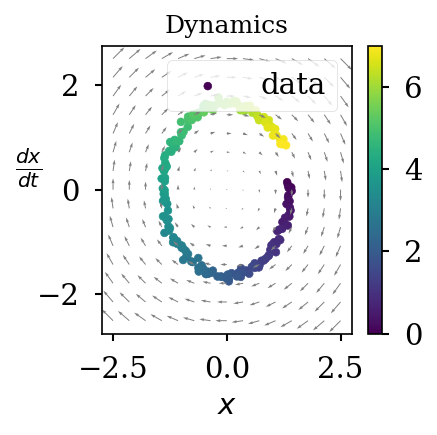

In [87]:
# field = get_field(gridsize=15, mass=0.9)
field = get_field(xmin=-2.5, xmax=2.5, ymin=-2.5, ymax=2.5, gridsize=15, mass=1.4)
data = get_dataset(seed=args.seed, samples=100, mass=1.4)

# plot config
fig = plt.figure(figsize=(3, 3))

# x, y, dx, dy, t = get_trajectory(mass=1.5, y0=np.array([1,0]))
x, y, dx, dy, t = get_trajectory(mass=1.4, y0=np.array([1.5, 0.3]))
cs = plt.scatter(x,y,c=t,s=14, label='data')
plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
           cmap='gray_r', color=(.5,.5,.5))
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics")
plt.legend(loc='upper right')
plt.colorbar(cs)

plt.tight_layout()

Observe changes to the above plot if the timespan for the training data is changed to $[0, 3]$ instead. The spring-mass system has a periodic orbit in phase space - see the animation on https://en.wikipedia.org/wiki/Phase_space, so the scatter points will span only half of the orbit in that case. This can affect the ability of the learnt model to generalize.

It is intuitive to visualize the periodicity of the motion in 2D as we add more data. This would be very difficult for higher-dimensional states.

In [88]:
data['x'].shape

(8750, 2)

In [89]:
# data['x'].shape : 8750 x 2 (for t=[0, 7])
# data['x'].shape: 4350 x 2 (for t=[0, 3.5]) # if samples is kept the same i.e. 100
# data['x'].shape: 8700 x 2 (for t=[0, 3.5]) # if samples is set to 200

In [90]:
x = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32).to(device)
test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32).to(device)
dxdt = torch.Tensor(data['dx']).to(device)
test_dxdt = torch.Tensor(data['test_dx']).to(device)

In [91]:
from rich.progress import track

In [92]:
args.use_rk4

False

In [93]:
stats = {'train_loss': [],
         'test_loss': []}
# for step in track(range(args.total_steps+1), description="Processing steps..."):
for step in track(range(3000), description="Processing steps..."):
  # train step
  dxdt_hat = model.rk4_time_derivative(x) if args.use_rk4 else model.time_derivative(x)
  # dxdt_hat = model.lfrog_time_derivative(x) if args.use_lp else model.time_derivative(x)
  loss = L2_loss(dxdt, dxdt_hat)
  loss.backward() ; optim.step() ; optim.zero_grad()

  # run test data
  test_dxdt_hat = model.rk4_time_derivative(test_x) if args.use_rk4 else model.time_derivative(test_x)
  # test_dxdt_hat = model.lfrog_time_derivative(test_x) if args.use_lp else model.time_derivative(test_x)
  test_loss = L2_loss(test_dxdt, test_dxdt_hat)

  # logging
  stats['train_loss'].append(loss.item())
  stats['test_loss'].append(test_loss.item())
  if args.verbose and step % args.print_every == 0:
    print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))

train_dxdt_hat = model.time_derivative(x)
train_dist = (dxdt - train_dxdt_hat)**2
test_dxdt_hat = model.time_derivative(test_x)
test_dist = (test_dxdt - test_dxdt_hat)**2
print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
  .format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
          test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))

Output()

Final train loss 1.8156e-03 +/- 2.9751e-05
Final test loss 1.7994e-03 +/- 2.8841e-05


In [94]:
args.baseline

False

In [95]:
# change names systematically if saving for different combinations of
if args.baseline:
  torch.save(model.state_dict(), os.path.join(args.save_dir, 'model_baseline.pt'))
else:
  torch.save(model.state_dict(), os.path.join(args.save_dir, 'model_HNN.pt'))

### Comparisons with baseline NN

In [96]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']

    # run model
    mesh_x = torch.tensor(np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

def integrate_model(model, t_span, y0, **kwargs):

    def fun(t, np_x):
        x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [97]:
plot_args = {'gridsize': 10,
             'LINE_SEGMENTS': 10,
             'ARROW_SCALE': 30,
             'ARROW_WIDTH': 6e-3,
             'LINE_WIDTH': 2}

In [98]:
def get_model(args, baseline, path):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)

    # model_name = 'baseline' if baseline else 'hnn'
    # path = "{}/spring{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

In [99]:
# base_model = torch.load(os.path.join(args.save_dir, 'model_baseline_t0to6.pt'))
# hnn_model = torch.load(os.path.join(args.save_dir, 'model_HNN_t0to6.pt'))

# we need to define model objects before calling load_state_dict. Override baseline in current
# args by passing as separate argument
# base_model = get_model(args, baseline=True, path=os.path.join(args.save_dir, 'model_baseline_t0to6.pt'))
# hnn_model = get_model(args, baseline=False, path=os.path.join(args.save_dir, 'model_HNN_t0to7_3000steps_correct.pt'))
hnn_model = get_model(args, baseline=False, path=os.path.join(args.save_dir, 'model_HNN.pt'))


field = get_field(xmin=-2.5, xmax=2.5, ymin=-2.5, ymax=2.5, gridsize=plot_args['gridsize'], mass=1.4)
# data = get_dataset()
if args.baseline:
  base_field = get_vector_field(base_model,
                              xmin=-2.5, xmax=2.5, ymin=-2.5, ymax=2.5,
                              mass=1.4,
                              gridsize=plot_args['gridsize'])
else:
  hnn_field = get_vector_field(hnn_model,
                             xmin=-2.5,
                             xmax=2.5,
                             ymin=-2.5,
                             ymax=2.5,
                             mass=1.4,
                             gridsize=plot_args['gridsize'])

<ipython-input-98-7a8ca6f5fd34>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [100]:
t_span = [0,7]
# y0 = np.asarray([1., 0])
y0 = np.asarray([1.5, 0.3])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 2000), 'rtol': 1e-12}
if args.baseline:
  base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
else:
  hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

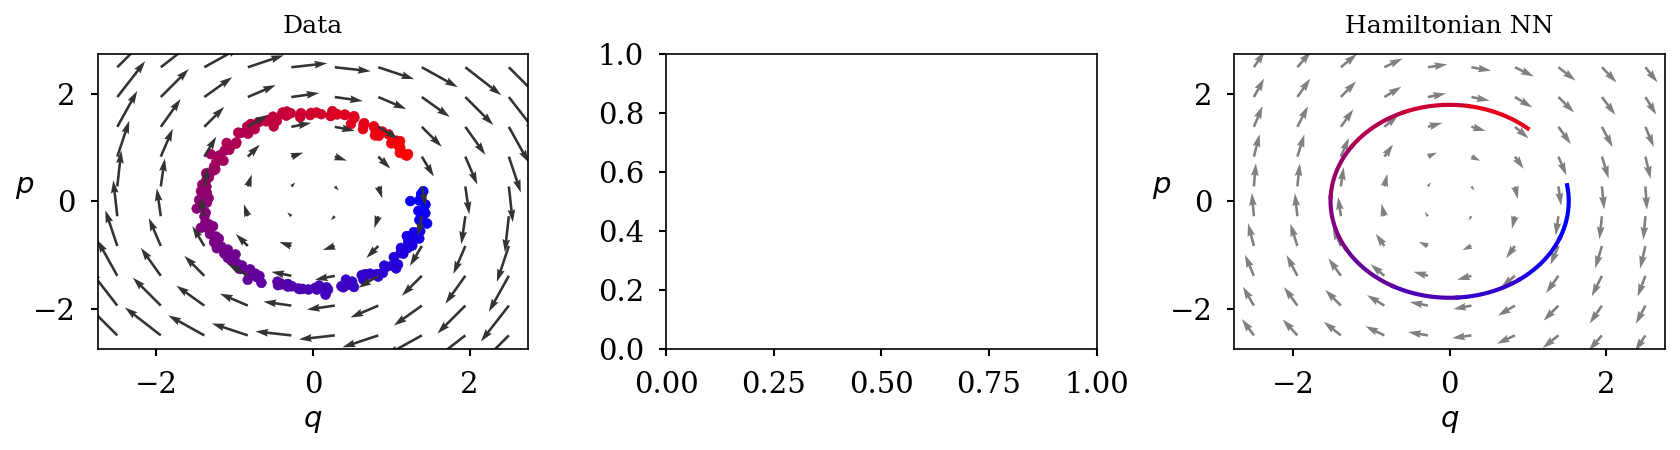

In [101]:
fig = plt.figure(figsize=(11.3, 3.1), facecolor='white')

# plot dynamics
fig.add_subplot(1, 3, 1, frameon=True)
x, y, dx, dy, t = get_trajectory(mass=1.4, y0=np.array([1.5, 0.3]))
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x,y, s=22, label='data', c=point_colors)

plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=plot_args['ARROW_SCALE'], width=plot_args['ARROW_WIDTH'], color=(.2,.2,.2))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

# # plot baseline
fig.add_subplot(1, 3, 2, frameon=True)
if args.baseline:
  plt.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
          cmap='gray_r', scale=plot_args['ARROW_SCALE'], width=plot_args['ARROW_WIDTH'], color=(.5,.5,.5))

  for i, l in enumerate(np.split(base_ivp['y'].T, plot_args['LINE_SEGMENTS'])):
      color = (float(i)/plot_args['LINE_SEGMENTS'], 0, 1-float(i)/plot_args['LINE_SEGMENTS'])
      plt.plot(l[:,0],l[:,1],color=color, linewidth=plot_args['LINE_WIDTH'])

  plt.xlabel("$q$", fontsize=14)
  plt.ylabel("$p$", rotation=0, fontsize=14)
  plt.title("Baseline NN", pad=10)

# plot HNN
fig.add_subplot(1, 3, 3, frameon=True)
plt.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=plot_args['ARROW_SCALE'], width=plot_args['ARROW_WIDTH'], color=(.5,.5,.5))

for i, l in enumerate(np.split(hnn_ivp['y'].T, plot_args['LINE_SEGMENTS'])):
    color = (float(i)/plot_args['LINE_SEGMENTS'], 0, 1-float(i)/plot_args['LINE_SEGMENTS'])
    plt.plot(l[:,0],l[:,1],color=color, linewidth=plot_args['LINE_WIDTH'])

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN", pad=10)

plt.tight_layout()

In [102]:
def integrate_models2(x0=np.asarray([1.5, 0.3]), t_span=[0,10], t_eval=None, noise_std=0.05):
    # integrate along ground truth vector field
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T

    # # rescale time to compensate for noise effects
    # t_span[1] *= 1 + .9*noise_std
    # t_eval *= 1 + .9*noise_std

    # integrate along baseline vector field
    if args.baseline:
      base_path = integrate_model(base_model, t_span, x0, **kwargs)
      base_x = base_path['y'].T
      _tmp = torch.tensor(true_x, requires_grad=True, dtype=torch.float32)
    else:
      # integrate along HNN vector field
      hnn_path = integrate_model(hnn_model, t_span, x0, **kwargs)
      hnn_x = hnn_path['y'].T
      _tmp = torch.tensor(true_x, requires_grad=True, dtype=torch.float32)

    if args.baseline:
      return true_x, base_x
    else:
      return true_x, hnn_x

In [103]:
x0 = np.asarray([1.5, 0.3])
# integration
t_span=[0,6.5]
t_eval = np.linspace(t_span[0], t_span[1], 2000)
if args.baseline:
  true_x, base_x = integrate_models2(x0=x0, t_span=t_span, t_eval=t_eval)
else:
  true_x, hnn_x = integrate_models2(x0=x0, t_span=t_span, t_eval=t_eval)

In [104]:
len(true_x), len(hnn_x)

(2000, 2000)

Text(0.5, 1.0, 'Prediction')

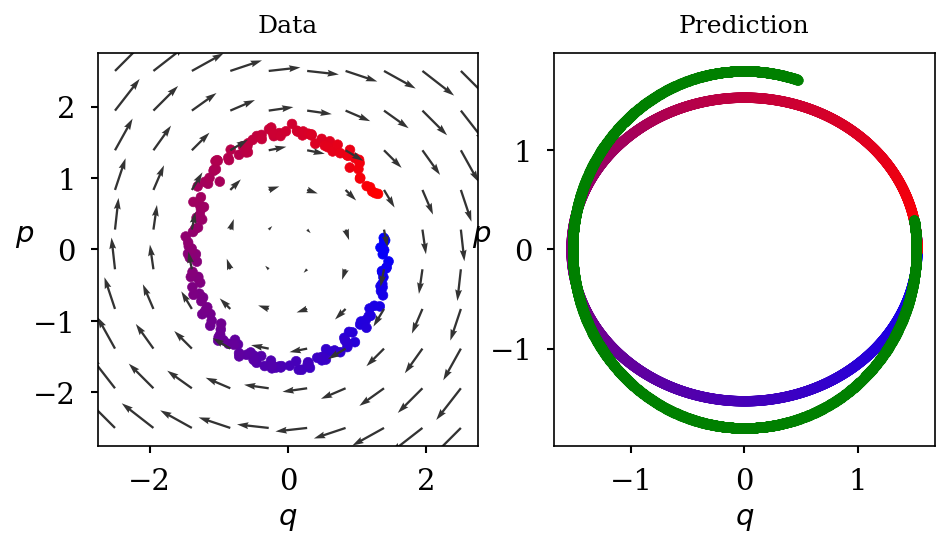

In [105]:
fig = plt.figure(figsize=(7.2, 3.4), facecolor='white')

# plot dynamics
fig.add_subplot(1, 2, 1, frameon=True)
x, y, dx, dy, t = get_trajectory(mass=1.4, y0=np.array([1.5, 0.3]))
N = len(x)
point_colors = [(i/N, 0, 1-i/N) for i in range(N)]
plt.scatter(x, y, s=22, label='train data', c=point_colors)


plt.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=plot_args['ARROW_SCALE'], width=plot_args['ARROW_WIDTH'], color=(.2,.2,.2))
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Data", pad=10)

fig.add_subplot(1, 2, 2, frameon=True)
N2 = len(true_x)
point_colors2 = [(i/N2, 0, 1-i/N2) for i in range(N2)]
plt.scatter(true_x[:,0], true_x[:,1], s=22, label='test datapoints', c=point_colors2)
if args.baseline:
  plt.scatter(base_x[:,0], base_x[:,1], s=22, label='pred', c='green')
else:
  plt.scatter(hnn_x[:,0], hnn_x[:,1], s=22, label='pred', c='green')

plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Prediction", pad=10)

- Caleb - something to look at with energy-based models.

- Basically, similar to how Taylor series could deal with entire functions (recover all evaluations with Taylor approximation) - entire functions in complex analysis - https://www.math.hkust.edu.hk/~machiang/5030/notes/Chap4.pdf

- There was some (unpublished) work on training energy based models, where even though they were stuck sampling from some local well, they could still approximate the global energy map! But we are not sure about what form the Hamiltonian would take for us to make claims about changing

- You may want to look into quarter-circle and half-circle settings too. How do they change the results?

- Difficult to answer (Xun): Would you still recover $H$ correctly with a million samples over the same timespan?

- Interesting question - can we do experimental design for this problem as a question of where in the phase space do we acquire points to learn the Hamiltonian well? (an alternate question would be to learn the global map of the Hamiltonian for different parameter settings).

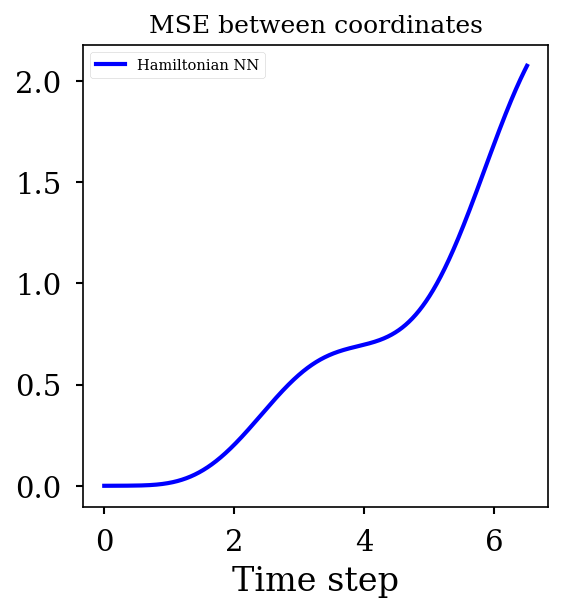

In [106]:
plt.figure(figsize=(4, 4))
plt.title("MSE between coordinates")
plt.xlabel('Time step')
# plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'b-', label='Hamiltonian NN', linewidth=2)
# plt.plot(t_eval, np.mean((true_x-hnn_x)**2, axis=1), 'b-', label='Hamiltonian NN', linewidth=2)
plt.legend(fontsize=7)

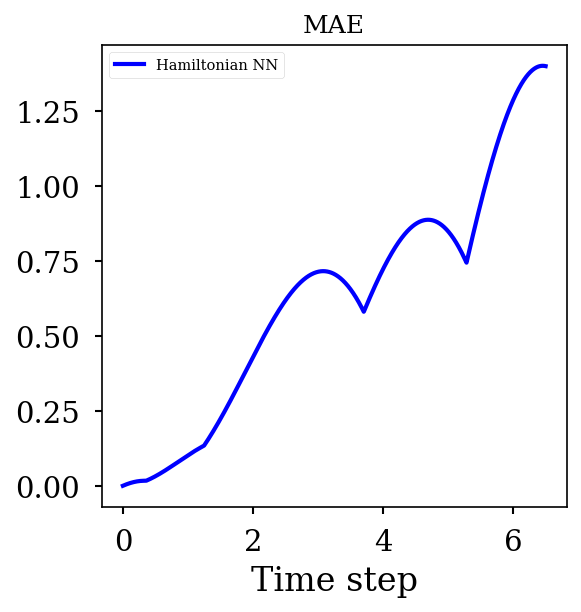

In [107]:
plt.figure(figsize=(4, 4))
plt.title("MAE")
plt.xlabel('Time step')
# plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
plt.plot(t_eval, np.mean(np.abs(true_x-hnn_x), axis=1), 'b-', label='Hamiltonian NN', linewidth=2)

# plot absolute error between individual coordinates.
# plt.plot(t_eval, np.abs(true_x - hnn_x)[:, 0], 'b-', label='abs error in q', linewidth=2)
# plt.plot(t_eval, np.abs(true_x - hnn_x)[:, 1], 'r-', label='abs error in p', linewidth=2)

plt.legend(fontsize=7)

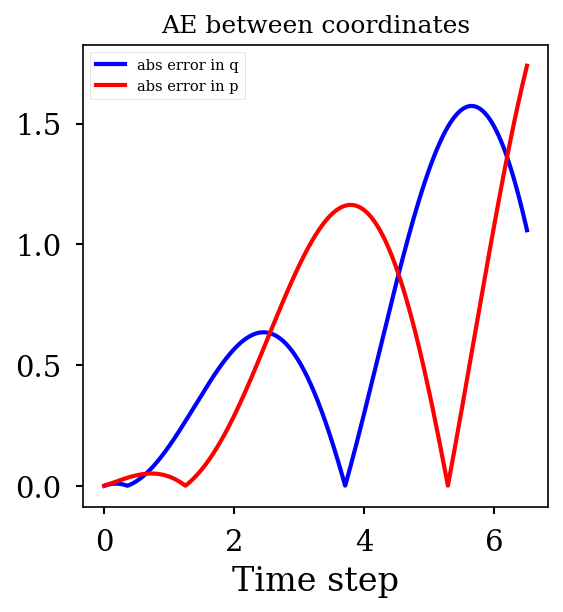

In [108]:
plt.figure(figsize=(4, 4))
plt.title("AE between coordinates")
plt.xlabel('Time step')
# plt.plot(t_eval, ((true_x-base_x)**2).mean(-1), 'r-', label='Baseline NN', linewidth=2)
# plt.plot(t_eval, np.mean(np.abs(true_x-hnn_x), axis=1), 'b-', label='Hamiltonian NN', linewidth=2)

# plot absolute error between individual coordinates.
plt.plot(t_eval, np.abs(true_x - hnn_x)[:, 0], 'b-', label='abs error in q', linewidth=2)
plt.plot(t_eval, np.abs(true_x - hnn_x)[:, 1], 'r-', label='abs error in p', linewidth=2)

plt.legend(fontsize=7)